In [5]:
manta_flavors = ['manta.superEnhanced', 'manta', 'manta.enhanced']
manta_flavors_names = ['less sensitive manta', 'default manta', 'more sensitive manta']    
trfermikit_flavor = 'trfermikit.unitigSupport.thinned'

## trfermikit has better recall-FDR trade-off than manta

In [6]:
import json

def get_confusion_counts(experiment, caller, svtype): 
    with open('{}/truvari-{}-pacbio-{}/summary.txt'.format(experiment, svtype, caller)) as json_file:
        return json.load(json_file)
    
def get_eventCount_callCount(experiment, caller, svtype): 
    try: 
        counts = get_confusion_counts(experiment, caller, svtype)
        event_count = counts['TP-base'] + counts['FN']
        call_count = counts['TP-base'] + counts['FP']
        return event_count, call_count
    except FileNotFoundError: 
        return None, None
    
def get_TPR_FDR(experiment, caller, svtype):
    try: 
        counts = get_confusion_counts(experiment, caller, svtype)
        event_count, call_count = get_eventCount_callCount(experiment, caller, svtype)
        TPR = counts['TP-base']/float(event_count)
        FDR = counts['FP']/float(call_count) 
        return TPR, FDR
    except (FileNotFoundError, ZeroDivisionError): 
        return None, None

def get_config(experiment): 
    with open('{}/config.json'.format(experiment)) as json_file:
        return json.load(json_file)

def get_TPR_FDR_config(experiment, caller, svtype):   
    TPR, FDR = get_TPR_FDR(experiment, caller, svtype)
    config = get_config(experiment)
    return TPR, FDR, config
    
def get_experiments(regions): 
    if regions == 'all': 
        # some experiments correspond to the same trfermikit configuration, e.g. 
        # INS/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/gapExtensionPenalties=1,0_gapOpenPenalties=6,26_singleBaseMatchReward=10_singleBaseMismatchPenalty=12/config.json
        # optimized_for_DELs/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/minCoverage=0_gapOpenPenalties=6,26_minUnitigMappingQuality=0_minUnitigBlockLength=25/config.json
        # but do not yield the same trfermikit callset, 
        # perhaps because of fermikit's stochasticity: https://github.com/lh3/fermikit#limitations
        experiments = ! ls -d \
            INS/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/* \
            optimized_for_DELs/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/* 
#             optimized_for_DELs/minSVSize_minRepeatLength_minUnitigBlockLength/data/*
        return experiments
    elif regions == 'intersecting exons and UTRs': 
        experiments = ! ls -d \
            exons_UTRs/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/* \
            exons_UTRs/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/* 
        return experiments
    elif regions == 'intersecting genes': 
        experiments = ! ls -d \
            genes/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/* \
            genes/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/* 
        return experiments
    else: 
        print('"{}" is not a valid value for "regions"'.format(regions))
        raise ValueError
             
def get_regions_tag(regions): 
    if regions == 'all': 
        return 'all_regions'
    elif regions == 'intersecting exons and UTRs': 
        return 'regions_intersecting_exons_and_UTRs'
    elif regions == 'intersecting genes': 
        return 'regions_intersecting_genes'
    else: 
        print('"{}" is not a valid value for "regions"'.format(regions))
        raise ValueError
    
def get_TPRs_FDRs_configs(caller, svtype, regions): 
    return tuple(zip(*[get_TPR_FDR_config(experiment, caller, svtype) for experiment in get_experiments(regions)]))


In [7]:
def get_stats(name, counts): 
    return '{} counts: {:.1f} +- {:.1f}'.format(name, np.mean(counts), np.std(counts))

def get_event_call_stats(caller_name, caller, svtype, regions):
    event_counts, call_counts = tuple(zip(*[get_eventCount_callCount(experiment, caller, svtype) for experiment in get_experiments(regions)]))
    return '{}<br>{} {}'.format(get_stats('event', event_counts), caller_name, get_stats('call', call_counts))

In [8]:
# https://stackoverflow.com/a/40239615/6674256 
# this is "is_pareto_efficient_simple"; "is_pareto_efficient_dumb" is buggy
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) numpy array
    :return: A (n_points, ) numpy boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, cost in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<cost, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def compute_pareto_front(trfermikit_FDRs, trfermikit_TPRs):
    return is_pareto_efficient(np.concatenate((
        1.0 - np.array(trfermikit_TPRs)[..., None],
        np.array(trfermikit_FDRs)[..., None]
    ), axis=1))

def zip_and_sort(*args):
    l = list(zip(*args))    
    l.sort(key=lambda x: x[0], reverse=False)
    return tuple(zip(*l))
        
def compute_operating_point(svtype, regions, manta_flavor='manta'): 
    trfermikit_TPRs, trfermikit_FDRs, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    trfermikit_TPRs, trfermikit_FDRs = zip_and_sort(trfermikit_TPRs, trfermikit_FDRs)

    _, manta_FDRs, _ = get_TPRs_FDRs_configs(manta_flavor, svtype, regions) 
    
    pareto_front_mask = compute_pareto_front(trfermikit_FDRs, trfermikit_TPRs)
    pareto_front_indices = np.argwhere(pareto_front_mask).flatten()
    
    trfermikit_FDRs = np.array(trfermikit_FDRs)
    trfermikit_TPRs = np.array(trfermikit_TPRs) 
    
    operating_point_index = pareto_front_indices[0]

    for pareto_front_index in pareto_front_indices: 
        if ( trfermikit_TPRs[pareto_front_index] > trfermikit_TPRs[operating_point_index] 
            and trfermikit_FDRs[pareto_front_index] < manta_FDRs[0] ):
            operating_point_index = pareto_front_index
            
    return operating_point_index 

In [9]:
import plotly.graph_objects as go
import numpy as np 

def write(fig, sub_directory, filename, data=None): 
    directory = 'paper_figures/{}'.format(sub_directory)
    
    import os
    import pathlib
    if not os.path.exists(directory):
        pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
    fig.write_image('{}/{}.pdf'.format(directory, filename))

    if data: 
        with open('{}/{}.json'.format(directory, filename), 'w') as data_file:
            json.dump(data, data_file)
    
def get_marker_core(symbol, size=16, color=None, linewidth=1, linecolor='black'): 
    return dict(
        symbol=symbol,
        line=dict(width=linewidth, color=linecolor),
        size=size,
        color=color
    )
   
def get_font(size=20, family='Arial'): 
    return dict(family=family, color='black', size=size)

def update_axes(fig, axis, text, linewidth=1.5): 
    update = { 
        'x': fig.update_xaxes,
        'y': fig.update_yaxes
    }
    
    update[axis]( 
        title=dict(text=text),
        showgrid=False,
        showline=True, 
        linewidth=linewidth, 
        linecolor='black',
        ticks='outside', 
        tickwidth=linewidth, 
        tickcolor='black', 
        ticklen=10,
    )

def plot_TPRs_FDRs(svtype, regions): 
    trfermikit_TPRs, trfermikit_FDRs, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    trfermikit_TPRs, trfermikit_FDRs = zip_and_sort(trfermikit_TPRs, trfermikit_FDRs)

    fig = go.Figure(data=go.Scatter(
        x=trfermikit_FDRs,
        y=trfermikit_TPRs,
        mode='markers',
        name='trfermikit',
        marker=get_marker_core('circle')
    ))
    
    pareto_front = compute_pareto_front(trfermikit_FDRs, trfermikit_TPRs)
    fig.add_trace(go.Scatter(
        x=np.array(trfermikit_FDRs)[pareto_front], 
        y=np.array(trfermikit_TPRs)[pareto_front],
        mode='markers',
        marker=get_marker_core('circle', size=7, linewidth=0, color='white'),
        showlegend=False
    ))   
    
    if svtype == 'DEL':
        trfermikit_operating_point_index = compute_operating_point(svtype, regions)
        fig.add_trace(go.Scatter(
            x=[np.array(trfermikit_FDRs)[trfermikit_operating_point_index]], 
            y=[np.array(trfermikit_TPRs)[trfermikit_operating_point_index]],
            mode='markers',
            marker=get_marker_core('circle-open', size=20, linewidth=3, color='red'),
            showlegend=False
        ))    

    for manta_flavor, manta_flavor_name in zip(manta_flavors, manta_flavors_names): 
        manta_TPRs, manta_FDRs, _ = get_TPRs_FDRs_configs(manta_flavor, svtype, regions) 
        fig.add_trace(go.Scatter(
            x=manta_FDRs, 
            y=manta_TPRs,
            mode='markers',
            name='{}'.format(manta_flavor_name),
            marker=get_marker_core('square'),
        ))   
    
    update_axes(fig, 'x', 'False Discovery Rate, FP/(TP + FP)') 
    update_axes(fig, 'y', 'Recall, TP/(TP + FN)') 
    fig.update_layout(
        plot_bgcolor='white',
        font=get_font(),
        title=dict(
            text='regions: {}<br>{}'.format(
                regions,
                get_event_call_stats('trfermikit', trfermikit_flavor, svtype, regions)
            ), 
            x=0.5,
            font=get_font(18)
        )
    )    

    write(
        fig, 
        sub_directory='TPRs_FDRs', 
        filename='{}-{}'.format(svtype, get_regions_tag(regions)),
    )
    
    fig.show()
        
def plot_TPRs_FDRs_all(svtype): 
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        plot_TPRs_FDRs(svtype, regions)
        


In [10]:
plot_TPRs_FDRs_all('DEL')

In [11]:
plot_TPRs_FDRs_all('INS')

## trfermikit is complementary to manta

In [12]:
def check(manta_callset): 
    if manta_callset != 'fn' and manta_callset != 'tp-base': 
        raise Exception
    else: 
        pass

def list_to_value(list_):
    try: 
        value, = list_
        return int(value)
    except ValueError: 
        return None
        
def tr_fermikit_TP_intersect_manta(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor): 
    list_ = ! $root/bin/bedtools intersect -u -wb -f $overlap_fraction -r \
      -a $experiment/truvari-$svtype-pacbio-$manta_flavor/$manta_callset".vcf" \
      -b $experiment/truvari-$svtype-pacbio-$trfermikit_flavor/tp-base.vcf \
      | wc -l 
#     debug = ! echo $experiment/truvari-$svtype-pacbio-$manta_flavor/$manta_callset".vcf"
#     print(debug)
    return list_to_value(list_)

def manta_less_tr_fermikit_TP(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor):
    list_ = ! $root/bin/bedtools subtract -A -f $overlap_fraction -r \
      -a $experiment/truvari-$svtype-pacbio-$manta_flavor/$manta_callset".vcf" \
      -b $experiment/truvari-$svtype-pacbio-$trfermikit_flavor/tp-base.vcf \
    | wc -l 
    return list_to_value(list_)

def get_counts(manta_callset, experiment, svtype, manta_flavor): 
    overlap_fraction = 0.9
    root = "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit"
    overlap_count = tr_fermikit_TP_intersect_manta(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor)
    manta_exclusive_count = manta_less_tr_fermikit_TP(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor)
    return overlap_count, manta_exclusive_count
    
def get_manta_fraction(manta_callset, experiment, svtype, manta_flavor):
    check(manta_callset)
    overlap_count, manta_exclusive_count = get_counts(manta_callset, experiment, svtype, manta_flavor)    
    try: 
        return overlap_count/float(overlap_count + manta_exclusive_count)
    except TypeError: 
        return None

def get_normalized_trfermikit_FDR(experiment, svtype, manta_flavor):
    _, trfermikit_FDR = get_TPR_FDR(experiment, trfermikit_flavor, svtype)
    _, manta_FDR = get_TPR_FDR(experiment, manta_flavor, svtype)
    try: 
        return trfermikit_FDR/manta_FDR
    except TypeError: 
        return None

def get_normalizedTrfermikitFDR_mantaFraction_config(experiment, svtype, manta_flavor): 
    normalized_trfermikit_FDR = get_normalized_trfermikit_FDR(
        experiment, 
        svtype, 
        manta_flavor
    )
    fraction_of_manta_FN = get_manta_fraction(
        manta_callset='fn', 
        experiment=experiment, 
        svtype=svtype, 
        manta_flavor=manta_flavor
    )
    config = get_config(experiment)
    return normalized_trfermikit_FDR, fraction_of_manta_FN, config
    
def get_normalizedTrfermikitFDRs_mantaFractions_configs(svtype, manta_flavor, regions):
    return tuple(zip(*[get_normalizedTrfermikitFDR_mantaFraction_config(experiment, svtype, manta_flavor) for experiment in get_experiments(regions)]))

def get_normalized_trfermikit_TPRs(manta_flavor, svtype, regions): 
    trfermikit_TPRs, _, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    manta_TPRs, _, _ = get_TPRs_FDRs_configs(manta_flavor, svtype, regions) 
    return np.array(trfermikit_TPRs)/np.array(manta_TPRs)


In [13]:
def get_marker_extra(color, title): 
    return dict(
        color=color,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title=dict(text=title)) # https://github.com/plotly/plotly.js/issues/1244
    )
    
def get_marker(color, title): 
    return {**get_marker_core('circle'), **get_marker_extra(color, title)}

def plot_manta_complementarity(svtype, manta_flavor, manta_flavor_name, regions): 
    normalized_trfermikit_FDRs, fractions_of_manta_FN, configs = get_normalizedTrfermikitFDRs_mantaFractions_configs(
        svtype, 
        manta_flavor,
        regions
    )
    trfermikit_TPRs, trfermikit_FDRs, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    normalized_trfermikit_TPRs = get_normalized_trfermikit_TPRs(manta_flavor, svtype, regions)

    trfermikit_TPRs, \
    trfermikit_FDRs, \
    normalized_trfermikit_TPRs, \
    normalized_trfermikit_FDRs, \
    fractions_of_manta_FN, \
    configs = zip_and_sort(
        trfermikit_TPRs,
        trfermikit_FDRs,
        normalized_trfermikit_TPRs, 
        normalized_trfermikit_FDRs, 
        fractions_of_manta_FN, 
        configs
    )
    
    fig = go.Figure(data=go.Scatter(
        x=normalized_trfermikit_FDRs,
        y=fractions_of_manta_FN,
        mode='markers',
        showlegend=False,     
        marker=get_marker(color=normalized_trfermikit_TPRs, title='(trfermikit recall)<br>/ (manta recall)'),
    ))
    update_axes(fig, 'x', '(trfermikit FDR) / (manta FDR)') 
    update_axes(fig, 'y', 'fraction of manta FNs recovered by trfermikit') 
    fig.update_layout(
        title=dict(
            text='manta flavor: {}; regions: {}<br>{}'.format(
                manta_flavor_name,
                regions,
                get_event_call_stats('trfermikit', trfermikit_flavor, svtype, regions)
            ), 
            x=0.5,
            font=get_font(18)
        ),
        plot_bgcolor='white',
        font=get_font(),
        width=600,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=0
        ),        
    )    
     
    if svtype == 'DEL':
        trfermikit_operating_point_index = compute_operating_point(svtype, regions)        
        fig.add_trace(go.Scatter(
            x=[normalized_trfermikit_FDRs[trfermikit_operating_point_index]], 
            y=[fractions_of_manta_FN[trfermikit_operating_point_index]],
            mode='markers',
            marker=get_marker_core('circle-open', size=20, linewidth=3, color='red'),
            showlegend=False
        ))    
        
    write(
        fig, 
        sub_directory='manta_complementarity', 
        filename='{}-{}-{}'.format(svtype, manta_flavor, get_regions_tag(regions)),
        data=[
            {
                'trfermikit_TPR': trfermikit_TPR, 
                'trfermikit_FDR': trfermikit_FDR,
                'normalized_trfermikit_TPR': normalized_trfermikit_TPR,
                'normalized_trfermikit_FDR': normalized_trfermikit_FDR,
                'fraction_of_manta_FN': fraction_of_manta_FN,
                'config': config
            }
            for (
                    trfermikit_TPR, 
                    trfermikit_FDR, 
                    normalized_trfermikit_TPR, 
                    normalized_trfermikit_FDR, 
                    fraction_of_manta_FN, 
                    config
                )
                in zip(
                    trfermikit_TPRs, 
                    trfermikit_FDRs,
                    normalized_trfermikit_TPRs, 
                    normalized_trfermikit_FDRs, 
                    fractions_of_manta_FN, 
                    configs
                )
        ]
    )
        
    fig.show()


def plot_manta_complementarity_allFlavors(svtype, regions):
    for manta_flavor, manta_flavor_name in zip(manta_flavors, manta_flavors_names): 
        plot_manta_complementarity(
            svtype, 
            manta_flavor,
            manta_flavor_name,
            regions
        )
        
def plot_manta_complementarity_allRegions(svtype):
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        plot_manta_complementarity(
            svtype, 
            'manta',
            'default manta',
            regions
        )

# plot_manta_complementarity_allFlavors('DEL', 'all')        
plot_manta_complementarity_allRegions('DEL')

In [14]:
plot_manta_complementarity_allRegions('INS')

## Create a trfermikit operating-point configuration that Pareto-dominates default manta



In [15]:
def create_default_config(regions): 
    svtype = 'DEL'
    manta_flavor = 'manta'    
    trfermikit_operating_point_index = compute_operating_point(svtype, regions, manta_flavor)        

    root = '/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit'
    json = '{}-{}-{}.json'.format(svtype, manta_flavor, get_regions_tag(regions))    
    
    ! jq --arg trfermikit_operating_point_index $trfermikit_operating_point_index \
        '.[$trfermikit_operating_point_index | tonumber].config | \
            del(.general) | \
            .makeRegions.ucscTable = "simpleRepeat" | \
            .makeRegions.minRepeatFunctionalOverlap = "1"' \
        paper_figures/manta_complementarity/$json \
        > $root/config.json

create_default_config(regions='all')

## Compute performance at default operating point

In [16]:
def compute_performance_at_default_operating_point(regions): 
    svtype = 'DEL'
    manta_flavor = 'manta'    
    trfermikit_operating_point_index = compute_operating_point(svtype, regions, manta_flavor)        

    root = '/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit'
    json = '{}-{}-{}.json'.format(svtype, manta_flavor, get_regions_tag(regions))    
    
    ! jq \
        --arg trfermikit_operating_point_index $trfermikit_operating_point_index \
        '.[$trfermikit_operating_point_index | tonumber] | del(.config.general)' \
        paper_figures/manta_complementarity/$json 
       
compute_performance_at_default_operating_point(regions='all')

{
  "trfermikit_TPR": 0.2948081264108352,
  "trfermikit_FDR": 0.4623301770275834,
  "normalized_trfermikit_TPR": 1.2344045368620038,
  "normalized_trfermikit_FDR": 0.9432990337583437,
  "fraction_of_manta_FN": 0.17259786476868327,
  "config": {
    "makeRegions": {
      "slop": "250",
      "minCoverage": "10",
      "maxCoverage": "200",
      "maxRegionLength": "100000",
      "minRepeatPeriod": "6",
      "minRepeatLength": "100",
      "functionalRegions": "none",
      "genomeBuild": "hg38",
      "overlappedFunctionalRegions": "false"
    },
    "makeCalls": {
      "singleBaseMatchReward": "10",
      "singleBaseMismatchPenalty": "12",
      "gapOpenPenalties": "10,35",
      "gapExtensionPenalties": "1,0",
      "minUnitigMappingQuality": "1"
    },
    "filterCalls": {
      "maxIntraClusterDistance": "500",
      "minSVSize": "50",
      "minUnitigMappingQuality": "0",
      "minUnitigBlockLength": "40"
    }
  }
}


In [17]:
compute_performance_at_default_operating_point(regions='intersecting genes')

{
  "trfermikit_TPR": 0.3023255813953488,
  "trfermikit_FDR": 0.4840598568640208,
  "normalized_trfermikit_TPR": 1.341793570219966,
  "normalized_trfermikit_FDR": 0.9697633804746087,
  "fraction_of_manta_FN": 0.18553149606299213,
  "config": {
    "makeRegions": {
      "slop": "250",
      "minCoverage": "10",
      "maxCoverage": "200",
      "maxRegionLength": "100000",
      "minRepeatPeriod": "6",
      "minRepeatLength": "100",
      "functionalRegions": "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/genes/Homo_sapiens.GRCh38.99.gene",
      "genomeBuild": "hg38",
      "overlappedFunctionalRegions": "true",
      "ucscTable": "simpleRepeat",
      "minRepeatFunctionalOverlap": "1"
    },
    "makeCalls": {
      "singleBaseMatchReward": "20",
      "singleBaseMismatchPenalty": "12",
      "gapOpenPenalties": "6,26",
      "gapExtensionPenalties": "1,0",
      "minUnitigMappingQuality": "1"
    },
    "filterCalls": {
      "maxIntraClusterDistance": "500",
      "minS

In [18]:
compute_performance_at_default_operating_point(regions='intersecting exons and UTRs')

{
  "trfermikit_TPR": 0.23076923076923078,
  "trfermikit_FDR": 0.5555555555555556,
  "normalized_trfermikit_TPR": 2.181818181818182,
  "normalized_trfermikit_FDR": 0.9150326797385622,
  "fraction_of_manta_FN": 0.16129032258064516,
  "config": {
    "makeRegions": {
      "slop": "250",
      "minCoverage": "5",
      "maxCoverage": "200",
      "maxRegionLength": "100000",
      "minRepeatPeriod": "6",
      "minRepeatLength": "100",
      "functionalRegions": "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/genes/Homo_sapiens.GRCh38.99.exon__five_prime_utr__three_prime_utr",
      "genomeBuild": "hg38",
      "overlappedFunctionalRegions": "true",
      "ucscTable": "simpleRepeat",
      "minRepeatFunctionalOverlap": "1"
    },
    "makeCalls": {
      "singleBaseMatchReward": "10",
      "singleBaseMismatchPenalty": "12",
      "gapOpenPenalties": "5,20",
      "gapExtensionPenalties": "1,0",
      "minUnitigMappingQuality": "1"
    },
    "filterCalls": {
      "maxIntraClu

## FNs appear to be always longer than TPs, and FNs appear to be longer in exons and UTRs than FNs in all tandem-repeat regions

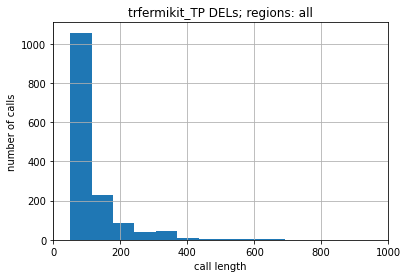

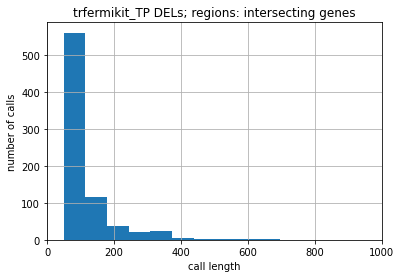

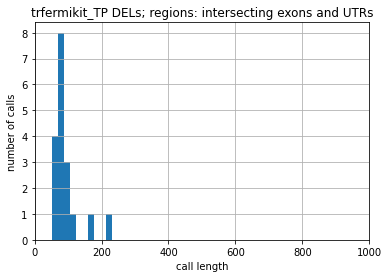

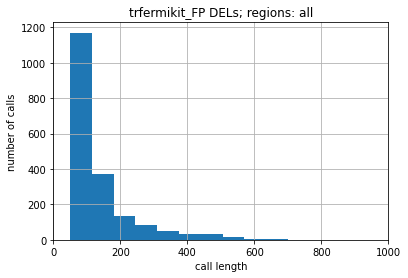

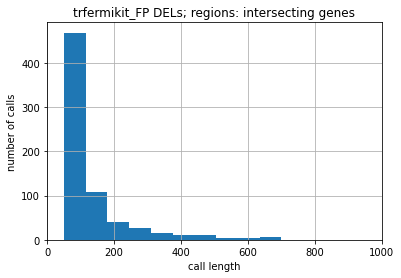

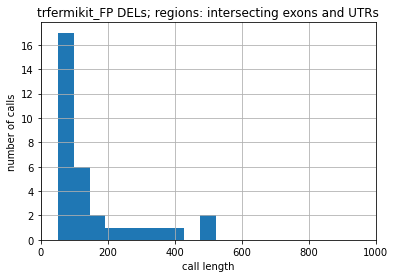

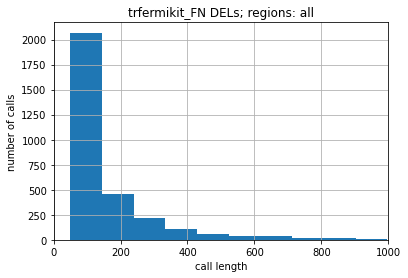

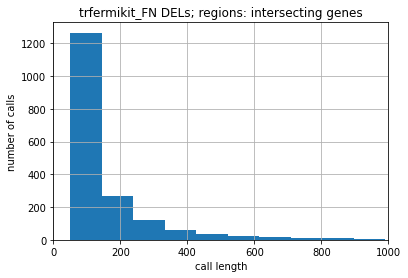

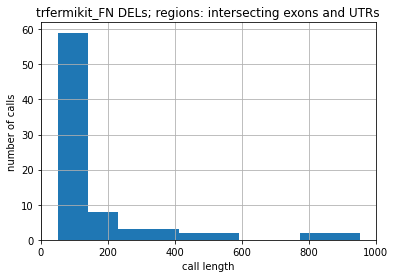

In [19]:
import pandas as pd

def plot_sv_lengths(svtype, calls_name): 
    sv_length_cutoff = 1000
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        df = pd.read_csv('sv_lengths/sv_lengths.{}.{}.{}.csv'.format(
            get_regions_tag(regions),
            svtype,
            calls_name
        ), names=['{} {}s; regions: {}'.format(calls_name, svtype, regions)])
        df = df[df < sv_length_cutoff]
        axes = df.hist()
        axes[0][0].set_xlim((0,sv_length_cutoff))
        axes[0][0].set_xlabel('call length')
        axes[0][0].set_ylabel('number of calls')
        
def plot_sv_lengths_all(svtype): 
    plot_sv_lengths(svtype, 'trfermikit_TP')
    plot_sv_lengths(svtype, 'trfermikit_FP')
    plot_sv_lengths(svtype, 'trfermikit_FN')    
    
plot_sv_lengths_all('DEL')

## Testing the hypothesis that long DELs are enriched in exons/UTRs relative to all tandem-repeat regions

In [20]:
def get_number_short_and_long_SVs(svtype, calls_name, regions, sv_length_cutoff): 
    sv_lengths = np.genfromtxt('sv_lengths/sv_lengths.{}.{}.{}.csv'.format(
        get_regions_tag(regions),
        svtype,
        calls_name
    ), delimiter=',')    
    number_events = len(sv_lengths)
    number_short_events = len(sv_lengths[sv_lengths < sv_length_cutoff])
    number_long_events = number_events - number_short_events
    return number_short_events, number_long_events

def statistical_test(svtype, calls_name, sv_length_cutoff):
    number_short_events_exonUTRs, number_long_events_exonsUTRs = get_number_short_and_long_SVs(
        svtype, calls_name, 'intersecting exons and UTRs', sv_length_cutoff
    )
    number_short_events_allRegions, number_long_events_allRegions = get_number_short_and_long_SVs(
        svtype, calls_name, 'all', sv_length_cutoff
    )

    observed = number_long_events_exonsUTRs
    expected = (
        number_long_events_allRegions*(number_short_events_exonUTRs+number_long_events_exonsUTRs)
    )/(number_short_events_allRegions+number_long_events_allRegions)    

    print('Assume null hypothesis that there is no association between')
    print('(i) whether SV is in exon/UTR or not')
    print('(ii) whether SV is long or short')

    print('Then observed number of long events in exons/UTRs ({}) is larger than expected ({:.1f})'.format(
        observed, expected))
    
    from scipy.stats import hypergeom
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
    [M, n, N] = [
        number_short_events_allRegions + number_long_events_allRegions, 
        number_long_events_allRegions, 
        number_short_events_exonUTRs + number_long_events_exonsUTRs
    ]
    print('And, probability that number of long events ', end='')
    print('in exons and UTRs is as large as observed, or larger ({:.2f}) is significant'.format(
        1.0 - hypergeom(M, n, N).cdf(number_long_events_exonsUTRs)
    ))
    
statistical_test('DEL', 'pacbio', 500)

Assume null hypothesis that there is no association between
(i) whether SV is in exon/UTR or not
(ii) whether SV is long or short
Then observed number of long events in exons/UTRs (8) is larger than expected (4.6)
And, probability that number of long events in exons and UTRs is as large as observed, or larger (0.04) is significant


## Hypothesis to explain why DEL recall is lower in exons/UTRs

We have established that long DELs are enriched in exons/UTRs. 
But longer DELs are known to have lower recall: 
https://docs.google.com/presentation/d/1YvqWvh08bMf29W-EVOFndHNKztiymJnUhvn0MGgGBNY/edit#slide=id.gb1851594c7_0_0
Thus the observed reduction in recall upon restricting regions to exons/UTRs could be 
explained by the enrichment in long DELs in exons/UTRs. 




## Method to prove that observed shift in FN length distribution (from all regions to those intersecting exons/UTRs) could quantitatively explain the observed reduction in recall

Infer the distribution of SV lengths in exons/UTRs. Call it the "target" distribution. 
Then use [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling#Algorithm) to choose a sample of SVs from all regions such that their lengths are distributed according to the target distribution. 
Then compute the reduction in recall for all regions versus the sub-sample of all regions. 
The hypothesis is that this reduction in recall will explain most of the observed 
reduction in recall on going from all regions to just those intersecting exons and UTRs. 

## Generality of long-DEL enrichment and recall reduction in exons/UTRs

Note that we have found enrichment of long DELs in one individual so far. 
This finding may not be typical of other individuals. 
Thus, our finding that there is a reduction in recall upon moving to exons/UTRs 
may not generalize to other truth sets. 


## Coverage over calls is not lower  when regions are restricted to exons and UTRs

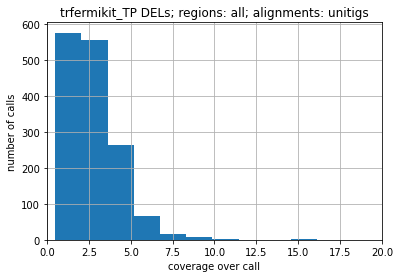

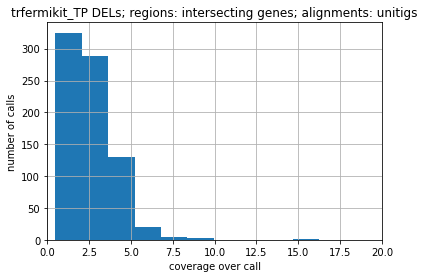

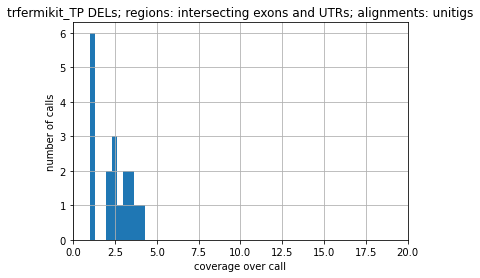

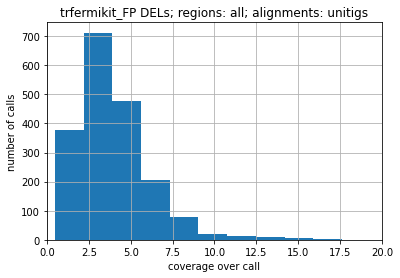

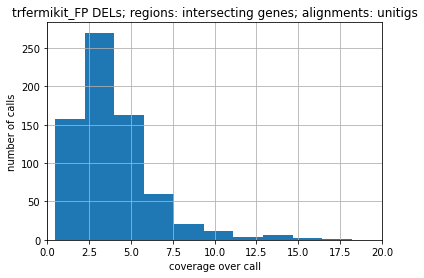

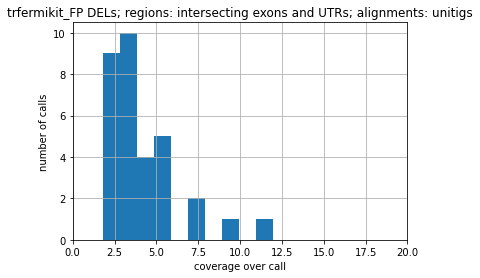

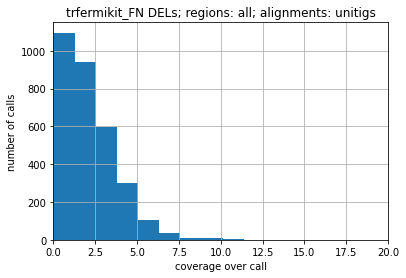

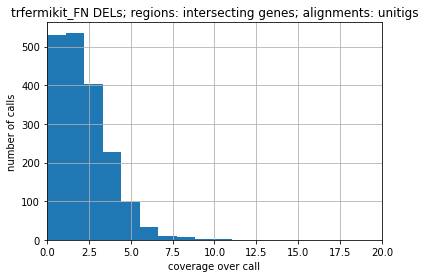

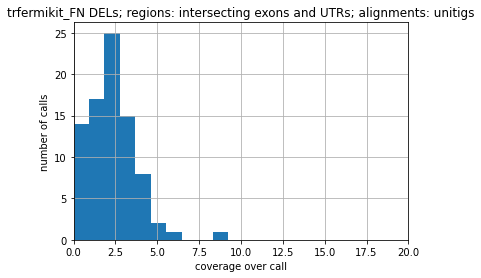

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sv_coverages(svtype, alignments_name, calls_name, coverage_cutoff): 
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        job = 'sv_coverages.{}.{}.{}.{}'.format(
            alignments_name,
            get_regions_tag(regions),
            svtype,
            calls_name
        )
        df = pd.read_csv('sv_coverages/{}/{}.csv'.format(job, job), names=[
            'chr', 
            'start', 
            'end',
            'coverage'
        ])
        df = df['coverage'][df['coverage'] < coverage_cutoff]        
        axes = df.hist()
        axes.set_xlim((0, coverage_cutoff))        
        axes.set_xlabel('coverage over call')
        axes.set_ylabel('number of calls')
        plt.title(
            '{} {}s; regions: {}; alignments: {}'.format(calls_name, svtype, regions, alignments_name)
        )
        plt.show()
        
def plot_sv_coverages_all(svtype, alignments_name, coverage_cutoff): 
    plot_sv_coverages(svtype, alignments_name, 'trfermikit_TP', coverage_cutoff)
    plot_sv_coverages(svtype, alignments_name, 'trfermikit_FP', coverage_cutoff)
    plot_sv_coverages(svtype, alignments_name, 'trfermikit_FN', coverage_cutoff)    
    
plot_sv_coverages_all('DEL', 'unitigs', 20)

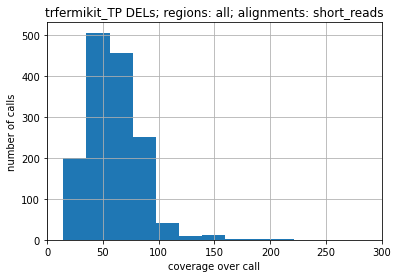

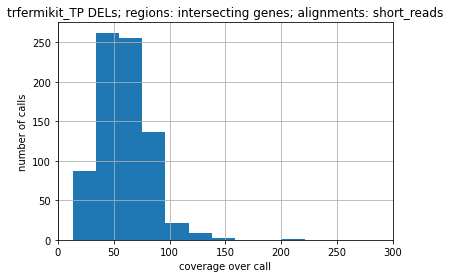

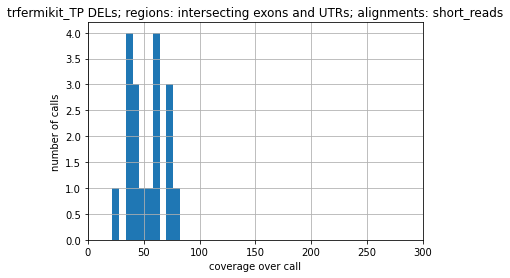

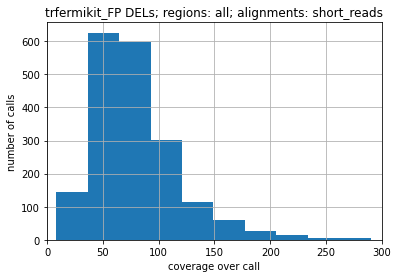

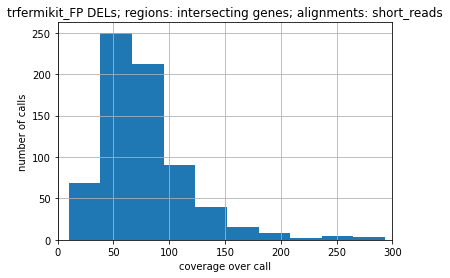

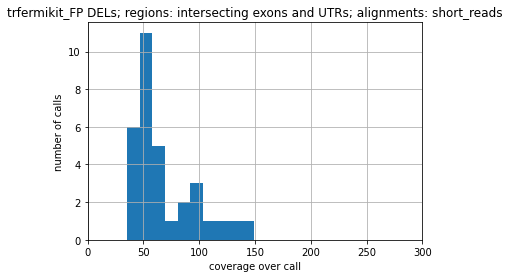

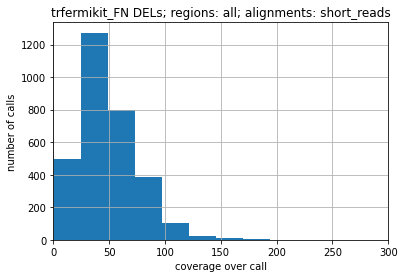

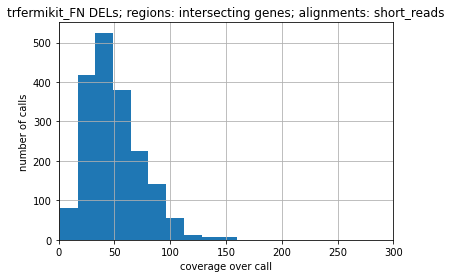

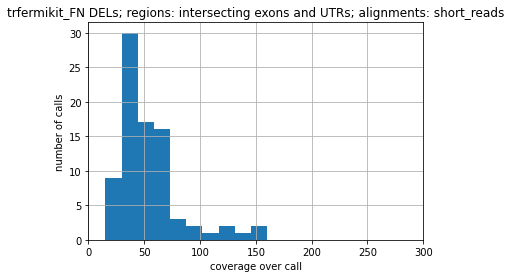

In [22]:
plot_sv_coverages_all('DEL', 'short_reads', 300)

## Gap penalties for trfermikit compared with minimap2

In [23]:
import numpy as np 

root = "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit"
default_trfermikit_config = get_config(root) # making this a global variable reduces disk accesses and speeds up alignments

def get_alignment_parameters(tool): 
    if tool == 'default-trfermikit': 
        return default_trfermikit_config['makeCalls']
    if tool == 'default-minimap2': 
        # asm10
        return { 
            'singleBaseMatchReward': '1',
            'singleBaseMismatchPenalty': '9',
            'gapOpenPenalties': '16,41',
            'gapExtensionPenalties': '2,1'
        }
    print('not valid tool')
    raise Exception
            
def get_gap_penalty(length, tool):
    # https://bioinformatics.stackexchange.com/questions/10594/what-do-the-symbols-mean-in-minimap2s-gap-cost-equation

    gap_open_penalty_1, gap_open_penalty_2 = map(int, get_alignment_parameters(tool)['gapOpenPenalties'].split(','))
    gap_extension_penalty_1, gap_extension_penalty_2 = map(int, get_alignment_parameters(tool)['gapExtensionPenalties'].split(','))
    
    if gap_extension_penalty_1 < gap_extension_penalty_2: raise Exception 
    if gap_open_penalty_1 + gap_extension_penalty_1 > gap_open_penalty_2 + gap_extension_penalty_2: raise Exception 

    return min([
        gap_open_penalty_1 + abs(length)*gap_extension_penalty_1, 
        gap_open_penalty_2 + abs(length)*gap_extension_penalty_2
    ])

def plot_gap_penalty(tool): 
    lengths = np.arange(0, 100, 2)
    gap_penalties = np.array([get_gap_penalty(length, tool) for length in lengths])

    match_score = int(get_alignment_parameters(tool)['singleBaseMatchReward'])
    normalized_gap_penalties = gap_penalties / match_score
    
    fig = go.Figure(data=go.Scatter(
        x=lengths,
        y=normalized_gap_penalties,
        mode='lines',
        showlegend=False,
        line=dict(
            width=5
        )
    ))    
    update_axes(fig, 'x', 'gap length (bases)') 
    update_axes(fig, 'y', '(gap penalty)/(single-base match reward)') 
    fig.update_yaxes(
        range=[0, 2.3],
        type='log',
        tickmode = 'array',
        tickvals = [1e0, 5, 1e1, 50, 1e2, 1e3],        
    )
    fig.update_layout(
        plot_bgcolor='white',
        font=get_font(),
        title=dict(
            text=None, 
            x=0.5
        ),
        width=400,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=0
        )        
    )
    
    write(fig, 'trfermikit_masks_INSs', '{}.gap_penalty'.format(tool))
    
    print(tool)
    fig.show()
    
plot_gap_penalty('default-trfermikit')
plot_gap_penalty('default-minimap2')

default-trfermikit


default-minimap2


## Why trfermikit doesn't work well on INSs: Relaxing gap penalties can mask INSs in short queries


Perturbing alignment parameters to favor alignment gaps can cause INSs to appear as DELs when the sample sequence is sufficiently small whereas DELs always manifest as gaps in the sample sequence regardless of its length: 


X=GGGGCGCTTC
Aprime=TCGTA
********************
tool = default-minimap2
********************


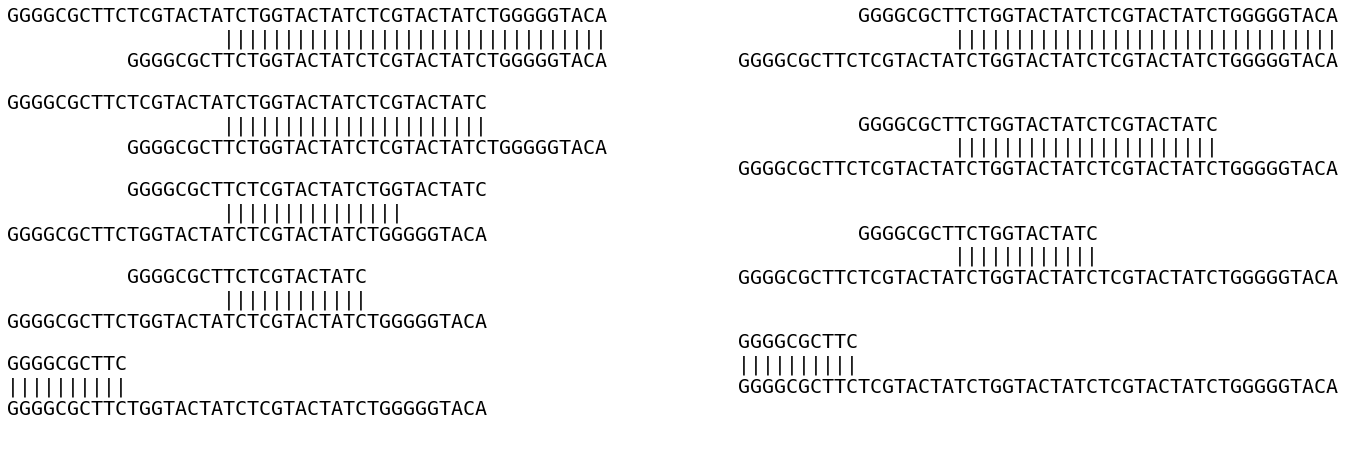

********************
tool = default-trfermikit
********************


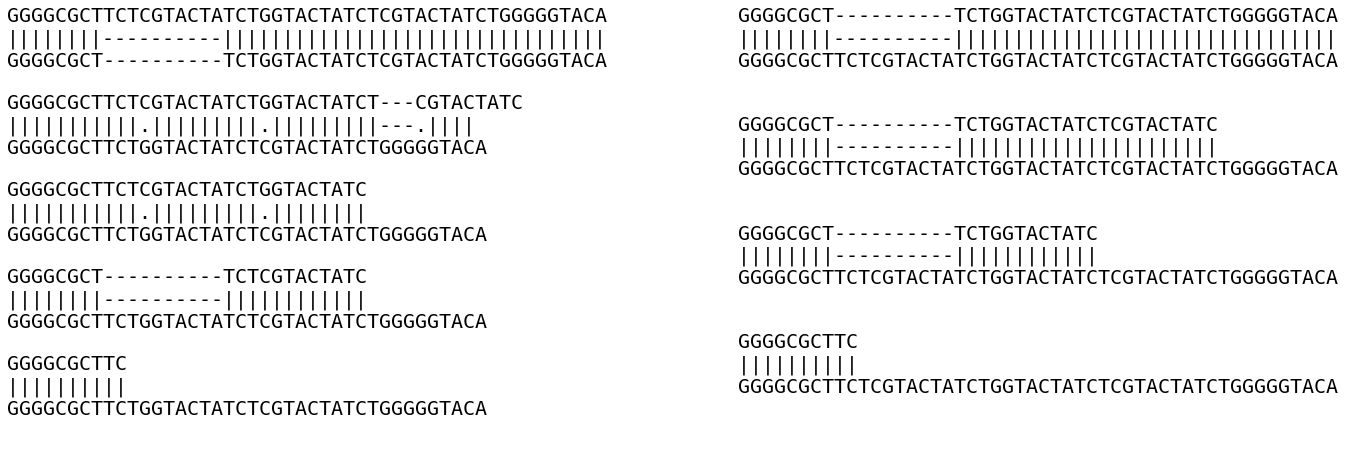

In [26]:
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec98
from Bio import Align

def get_gap_penalty_biopython(tool):
    return lambda start, length: -get_gap_penalty(length, tool)

def compute_alignment(query, reference, aligner):
    alignments = aligner.align(query, reference)

    # biopython docs: "The alignment score [...] has the same value for each alignment in alignments"
    if len(alignments) > 1: 
        pass
#         print('{} alignments for query: {}'.format(len(alignments), query))    
#         raise 

    return alignments[0]
   
def plot_truncated_alignments(axis, query, reference, tool, sub_query_step_size=1):
    aligner = Align.PairwiseAligner(
        match_score = int(get_alignment_parameters(tool)['singleBaseMatchReward']), 
        mismatch_score = -int(get_alignment_parameters(tool)['singleBaseMismatchPenalty']), 
        gap_score = get_gap_penalty_biopython(tool),
        mode = 'local')
    
    axis.axis('off')
    sub_query_lengths = np.arange(len(query), 2, -sub_query_step_size)    
    delta_alignment_y = 1/len(sub_query_lengths)
    alignment_ys = np.arange(1, 0, -delta_alignment_y)
    for alignment_y, sub_query_length in zip(alignment_ys, sub_query_lengths):
        alignment = compute_alignment(query[:sub_query_length], reference, aligner) 

        # https://github.com/biopython/biopython/blob/master/Bio/Align/__init__.py#L1035
        # https://en.wikipedia.org/wiki/Monospaced_font
        # Don't use PIL to write text to pdf: https://stackoverflow.com/questions/35387280/fonts-aliasing-in-pillow
        axis.text(0, 
                 alignment_y, 
                 str(alignment), 
                 fontdict=get_font(
                     family='monospace'
                 ), 
                 verticalalignment='top') 

def generate_random_sequence(length):
    return ''.join(np.random.choice(['A', 'C', 'G', 'T'], size=length, p=0.25*np.ones(4)))

def mutate_sequence(sequence):
    import copy
    sequence_prime = copy.deepcopy(sequence)
    sequence_prime = list(sequence_prime) 
    random_position = np.random.randint(0, len(sequence_prime))
    old_nucleotide = sequence_prime[random_position]
    possible_new_nucleotides = ['A', 'C', 'G', 'T']
    possible_new_nucleotides.remove(old_nucleotide)
    new_nucleotide = np.random.choice(possible_new_nucleotides, p=(1/3)*np.ones(3))
    sequence_prime[random_position] = new_nucleotide
    return ''.join(sequence_prime)
 
np.random.seed(0)
X = generate_random_sequence(10)
print(f'X={X}')
A = generate_random_sequence(5)
Aprime = mutate_sequence(A)
print(f'Aprime={Aprime}')
B = generate_random_sequence(5)
Y = generate_random_sequence(10)

def plot_INS_and_DEL(short_sequence, long_sequence, tool):
    grid = (1, 2)
    plt.subplots(*grid, figsize=(24,8))        
    print('********************')
    print('tool = {}'.format(tool))
    print('********************')
    plot_truncated_alignments(plt.subplot(*grid, 1), long_sequence, short_sequence, tool, sub_query_step_size=10) 
    plot_truncated_alignments(plt.subplot(*grid, 2), short_sequence, long_sequence, tool, sub_query_step_size=10) 
    plt.savefig('paper_figures/trfermikit_masks_INSs/{}.alignments.pdf'.format(tool))            
    plt.show()

def plot_minimap2_and_trfermikit(short_sequence, long_sequence): 
    plot_INS_and_DEL(short_sequence, long_sequence, 'default-minimap2')
    plot_INS_and_DEL(short_sequence, long_sequence, 'default-trfermikit')

plot_minimap2_and_trfermikit(
    short_sequence = X + A + B + Aprime + B + Y,
    long_sequence = X + Aprime + B + A + B + Aprime + B + Y
)